In [1]:
# %%
# 程式碼區塊 1：載入套件與資料

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 設定全局字體
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.unicode_minus'] = False
# 讀取資料
df = pd.read_csv("VerbalFluencyTest_rawdata.csv")
df.head()


,NUMBER,Age,Gender,Analysis Result,Verbal Fluency,Lexical Richness,Speech Rate,Accuracy,Voice Fluency
0,1,63,2,Normal,0.895205,0.684282,0.854517,1.000000,0.940569
1,2,67,2,Dementia,0.563597,0.267195,0.853779,0.653680,0.442837
2,3,69,1,Dementia,0.227932,0.136541,0.317103,0.317103,0.616538
3,4,58,2,Normal,1.000000,0.683591,0.939348,1.000000,0.895420
4,5,72,2,Dementia,0.606681,0.201904,0.407563,0.541407,0.436888


In [8]:
# %%
# 程式碼區塊 2：資料前處理（篩選與標準化）

# 類別編碼與特徵選取（保持不變）
df_model = df[df["Analysis Result"] != "Inconclusive"].copy().dropna()
label_encoder = LabelEncoder()
df_model["label"] = label_encoder.fit_transform(df_model["Analysis Result"])

features = ["Verbal Fluency", "Lexical Richness", "Speech Rate", "Accuracy", "Voice Fluency"]
X = df_model[features]
y = df_model["label"]

# 先分割資料再標準化 (關鍵修正點)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,  # 這裡使用原始未標準化數據
    test_size=0.3, 
    random_state=42,
    stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

# 標準化流程修正
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 僅用訓練集擬合
X_val_scaled = scaler.transform(X_val)         # 應用相同參數
X_test_scaled = scaler.transform(X_test)       # 應用相同參數

# 確認形狀與比例
print(f"訓練集形狀: {X_train_scaled.shape} ({len(X_train_scaled)/len(X):.2%})")
print(f"驗證集形狀: {X_val_scaled.shape} ({len(X_val_scaled)/len(X):.2%})")
print(f"測試集形狀: {X_test_scaled.shape} ({len(X_test_scaled)/len(X):.2%})")

訓練集形狀: (672, 5) (70.00%)
驗證集形狀: (144, 5) (15.00%)
測試集形狀: (144, 5) (15.00%)


In [9]:
from sklearn.utils import class_weight
print("訓練集類別比例:", {0: sum(y_train==0), 1: sum(y_train==1)})
print("測試集類別比例:", {0: sum(y_test==0), 1: sum(y_test==1)})

訓練集類別比例: {0: 97, 1: 575}
測試集類別比例: {0: 21, 1: 123}


In [ ]:
# %%
# 程式碼區塊 3：模型訓練與評估
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

# 設定評估指標
scoring = { 
    'roc_auc': 'roc_auc',
    'f1': 'f1',
    'recall': 'recall',
    'precision': 'precision'
}

from sklearn.model_selection import StratifiedKFold
# 設定交叉驗證
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 修改後的程式碼區塊3：比較內建平衡機制
updated_models = [
    {
        'name': 'LogisticRegression_Balanced',
        'model': LogisticRegression(
            class_weight='balanced',  # 啟用內建平衡
            max_iter=1000,
            random_state=42
        )
    },
    {
        'name': 'RandomForest_Balanced',
        'model': RandomForestClassifier(
            class_weight='balanced',
            n_estimators=100,
            random_state=42
        )
    },
    {
        'name': 'XGBoost_Weighted',
        'model': XGBClassifier(
            scale_pos_weight=len(y_train[y_train==1])/len(y_train[y_train==0]),  # 575/97 ≈ 5.93
            eval_metric='logloss',
            use_label_encoder=False
        )
    },
    {
        'name': 'SVM_Balanced',
        'model': SVC(
            class_weight='balanced',  # 啟用類別權重
            probability=True,
            kernel='rbf',
            random_state=42
        )
    }
]

# 重新執行比較
results = []
for model_info in updated_models:
    scores = cross_validate(
        estimator=model_info['model'],
        X=X_train_scaled,
        y=y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )
    
    results.append({
        'model': model_info['name'],
        'auc_mean': np.mean(scores['test_roc_auc']),
        'auc_std': np.std(scores['test_roc_auc']),
        'f1_mean': np.mean(scores['test_f1']),
        'recall_mean': np.mean(scores['test_recall']),
        'precision_mean': np.mean(scores['test_precision'])
    })

# 顯示結果
results_df = pd.DataFrame(results).sort_values(by='auc_mean', ascending=False)
print(results_df[['model', 'auc_mean', 'auc_std', 'f1_mean', 'recall_mean', 'precision_mean']])

                         model  auc_mean   auc_std   f1_mean  recall_mean  \
1        RandomForest_Balanced  0.992741  0.009682  0.983535     0.984362   
3                 SVM_Balanced  0.991881  0.007231  0.976150     0.961766   
2             XGBoost_Weighted  0.990271  0.010622  0.983596     0.989564   
0  LogisticRegression_Balanced  0.988745  0.011659  0.975056     0.958258   

   precision_mean  
1        0.982813  
3        0.991132  
2        0.977815  
0        0.992851  


=== 驗證集詳細評估 ===
AUC-ROC: 1.000
F1: 1.000
Recall: 1.000
Precision: 1.000

=== 測試集最終報告 ===
              precision    recall  f1-score   support

      Normal      0.952     0.952     0.952        21
    Dementia      0.992     0.992     0.992       123

    accuracy                          0.986       144
   macro avg      0.972     0.972     0.972       144
weighted avg      0.986     0.986     0.986       144



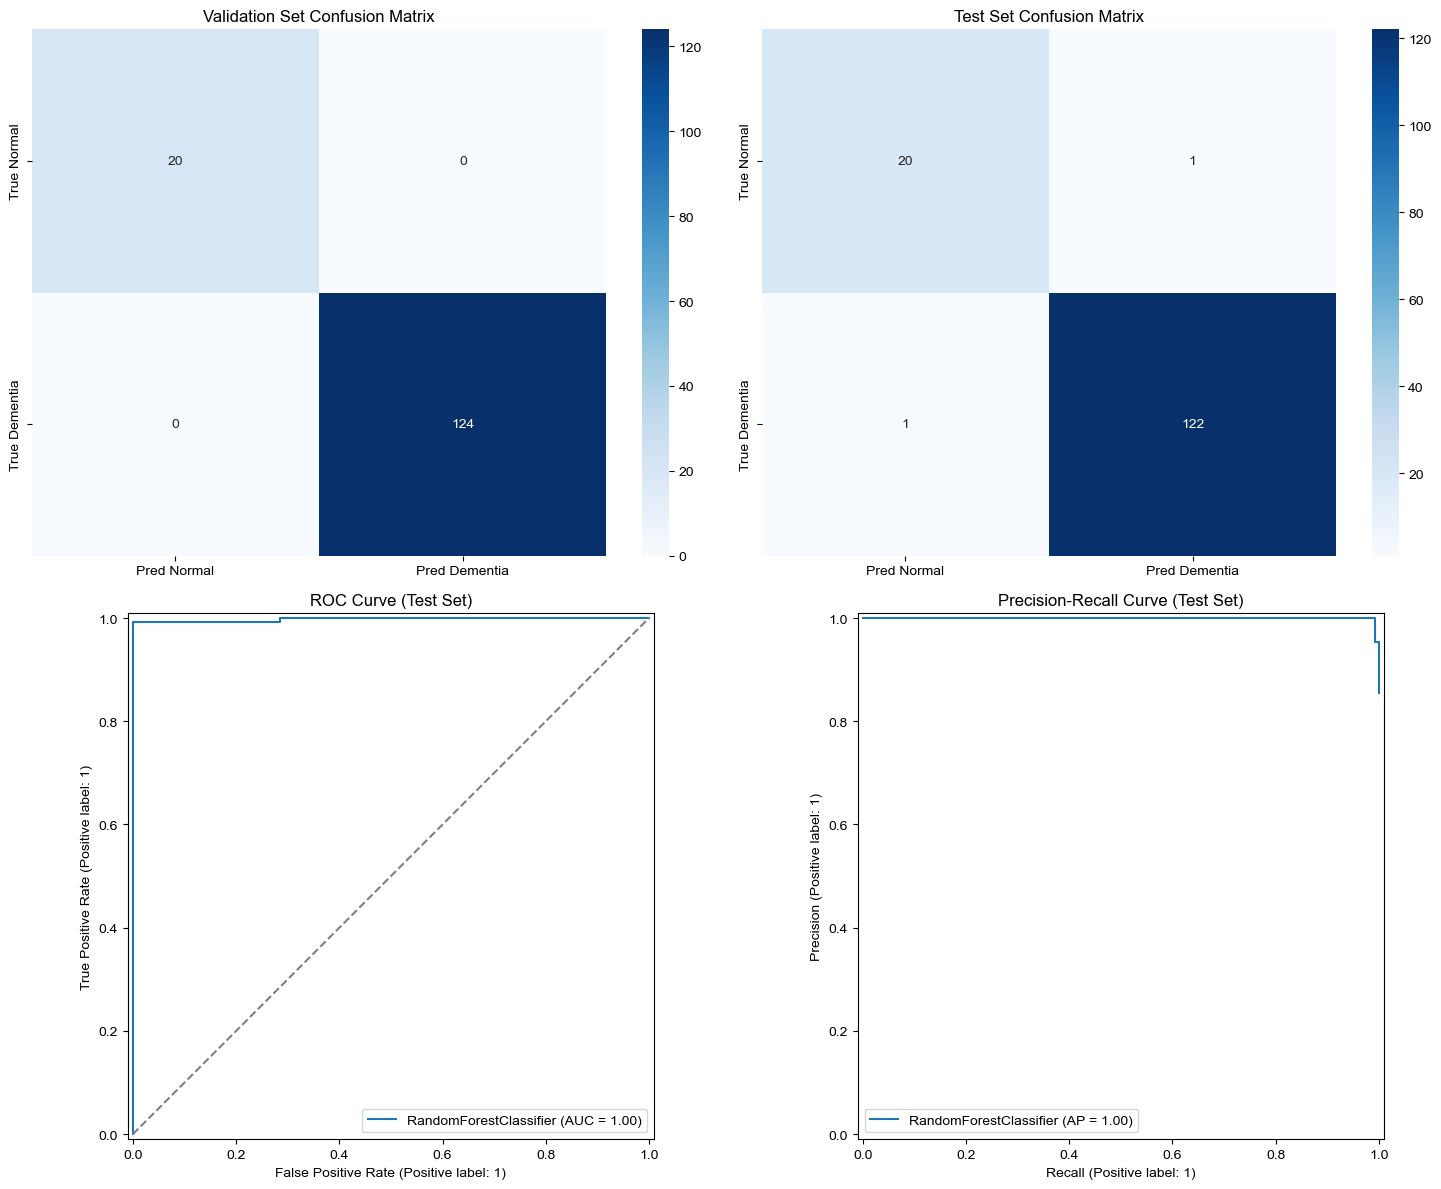

C:\Users\user\AppData\Local\Temp\ipykernel_4216\850307112.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')


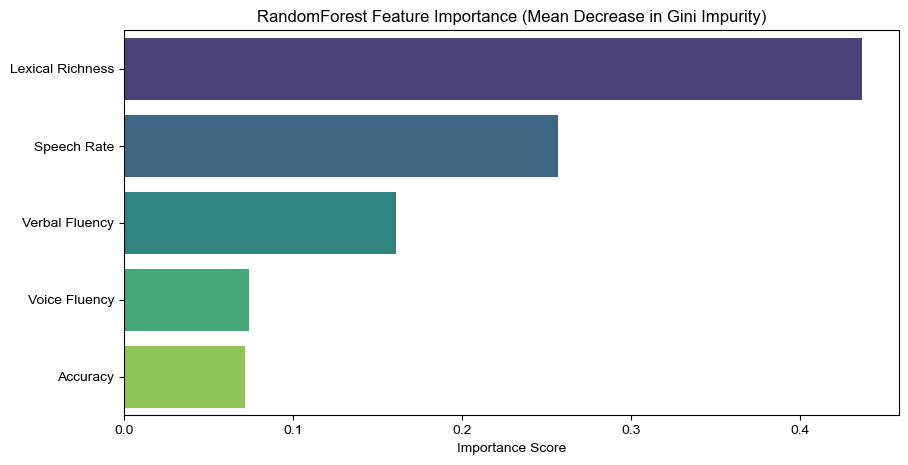

In [12]:
# 程式碼區塊4：最佳模型訓練與評估
from sklearn.metrics import (roc_auc_score, f1_score, recall_score, 
                             precision_score, confusion_matrix, 
                             classification_report, RocCurveDisplay,
                             PrecisionRecallDisplay)
import matplotlib.pyplot as plt
import seaborn as sns

# 初始化最佳模型（根據交叉驗證結果選擇RandomForest_Balanced）
best_model = RandomForestClassifier(
    class_weight='balanced_subsample',
    n_estimators=100,
    random_state=42
)

# 完整訓練流程
best_model.fit(X_train_scaled, y_train)  # 使用全部訓練數據

# 驗證集評估
print("=== 驗證集詳細評估 ===")
y_val_pred = best_model.predict(X_val_scaled)
y_val_proba = best_model.predict_proba(X_val_scaled)[:,1]

# 關鍵指標計算
val_metrics = {
    'AUC-ROC': roc_auc_score(y_val, y_val_proba),
    'F1': f1_score(y_val, y_val_pred),
    'Recall': recall_score(y_val, y_val_pred),
    'Precision': precision_score(y_val, y_val_pred)
}

# 格式化輸出
for metric, value in val_metrics.items():
    print(f"{metric}: {value:.3f}")

# 測試集最終評估
print("\n=== 測試集最終報告 ===")
y_test_pred = best_model.predict(X_test_scaled)
y_test_proba = best_model.predict_proba(X_test_scaled)[:,1]

# 完整分類報告
print(classification_report(y_test, y_test_pred, 
                           target_names=['Normal', 'Dementia'],
                           digits=3))

# 可視化分析
fig, ax = plt.subplots(2, 2, figsize=(15, 12))

# 混淆矩陣（驗證集）
sns.heatmap(confusion_matrix(y_val, y_val_pred), 
            annot=True, fmt='d', ax=ax[0,0],
            xticklabels=['Pred Normal', 'Pred Dementia'],
            yticklabels=['True Normal', 'True Dementia'], cmap='Blues')
ax[0,0].set_title("Validation Set Confusion Matrix")

# 混淆矩陣（測試集）
sns.heatmap(confusion_matrix(y_test, y_test_pred), 
            annot=True, fmt='d', ax=ax[0,1],
            xticklabels=['Pred Normal', 'Pred Dementia'],
            yticklabels=['True Normal', 'True Dementia'], cmap='Blues')
ax[0,1].set_title("Test Set Confusion Matrix")

# ROC曲線
RocCurveDisplay.from_estimator(best_model, X_test_scaled, y_test, ax=ax[1,0])
ax[1,0].plot([0, 1], [0, 1], linestyle='--', color='gray')
ax[1,0].set_title("ROC Curve (Test Set)")

# PR曲線
PrecisionRecallDisplay.from_estimator(best_model, X_test_scaled, y_test, ax=ax[1,1])
ax[1,1].set_title("Precision-Recall Curve (Test Set)")

plt.tight_layout()
plt.show()

# 特徵重要性分析（隨機森林專用）
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title("RandomForest Feature Importance (Mean Decrease in Gini Impurity)")
plt.xlabel("Importance Score")
plt.ylabel("")
plt.show()

In [13]:
# 檢查特徵與標籤的關聯性
from scipy.stats import pointbiserialr

correlations = []
for feature in features:
    corr, _ = pointbiserialr(df_model[feature], df_model["label"])
    correlations.append(abs(corr))

pd.DataFrame({'Feature': features, '|Correlation|': correlations}) \
  .sort_values('|Correlation|', ascending=False)

,Feature,|Correlation|
1,Lexical Richness,0.751787
2,Speech Rate,0.678575
0,Verbal Fluency,0.672804
3,Accuracy,0.641676
4,Voice Fluency,0.567655
